In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
#import statsmodels
import matplotlib.dates as mdates

import pickle
import warnings

from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.notebook import tqdm
from sklearn.model_selection import TimeSeriesSplit


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
"""
Load the data
"""
with open('../../Models/GRU_Hybrid/grouped_data_tensors.pkl', 'rb') as file:
    grouped_data_tensors = pickle.load(file)

In [3]:
"""
Get data
"""
#df = pd.read_parquet('../../../Datasets/data_processed_half_Basti_final.parq')
df = pd.read_parquet('../../Datasets/data_processed_half.parq')


#-----------------------Data cleaning-----------------------
# Drop columns and charging stations  
df = df.drop(['plugType1', 'plugType2', 'plugCCS', 'plugTesla', 'plugChademo', 'owner'], axis=1)  

display(df)

,timestamp_rounded,longitude,latitude,status_3_ratio,hours_elapsed
0,2023-08-10 13:30:00,8.141860,55.555610,0.500,0.0
1,2023-08-10 14:00:00,8.141860,55.555610,0.875,0.5
2,2023-08-10 14:30:00,8.141860,55.555610,0.500,1.0
3,2023-08-10 15:00:00,8.141860,55.555610,0.750,1.5
4,2023-08-10 15:30:00,8.141860,55.555610,0.875,2.0
...,...,...,...,...,...
893816,2023-10-16 09:00:00,12.659088,55.595629,0.500,1603.5
893817,2023-10-16 09:30:00,12.659088,55.595629,0.500,1604.0
893818,2023-10-16 10:00:00,12.659088,55.595629,0.500,1604.5
893819,2023-10-16 10:30:00,12.659088,55.595629,0.750,1605.0


# Data Preprocessing

### Time features

In [4]:
"""
Add time columns 
"""
# Assuming df is your DataFrame containing the data
df['timestamp_rounded'] = pd.to_datetime(df['timestamp_rounded'])

# Extract hour of day, minute of hour, and day of week
df['hour_of_day'] = df['timestamp_rounded'].dt.hour
df['minute_of_hour'] = df['timestamp_rounded'].dt.minute
df['day_of_week'] = df['timestamp_rounded'].dt.dayofweek

# Convert hour and minute to cyclic coordinates
df['hour_sin'] = np.sin(df['hour_of_day'] * (2. * np.pi / 24))
df['hour_cos'] = np.cos(df['hour_of_day'] * (2. * np.pi / 24))
df['minute_sin'] = np.sin(df['minute_of_hour'] * (2. * np.pi / 60))  # Cyclic transformation for minutes
df['minute_cos'] = np.cos(df['minute_of_hour'] * (2. * np.pi / 60))

# Convert day to cyclic coordinates
df['day_sin'] = np.sin(df['day_of_week'] * (2. * np.pi / 7))
df['day_cos'] = np.cos(df['day_of_week'] * (2. * np.pi / 7))

# Drop the original timestamp and extracted features if they are no longer needed directly
df.drop(['hour_of_day', 'minute_of_hour', 'day_of_week'], axis=1, inplace=True)

In [5]:
"""
Add significant lags for each station 
"""
significant_lags_weekly = [1, 2, 17, 34, 51, 68, 85, 119, 136, 153, 170, 187, 204, 221, 238]  #based on time series analysis 
significant_lags_daily  = [1, 2, 17, 34]

# Creating new features for the significant lags
for lag in significant_lags_weekly:
    df[f'status_3_ratio_lag_{lag}'] = df['status_3_ratio'].shift(lag).astype('float32')

# After creating lagged features, you may need to drop the NaN values created due to shifting
df = df.dropna()


"""
Normalize the features 
"""
# Now, normalize your dataset, including the new lagged features
scaler = MinMaxScaler()
features_to_normalize = df.columns.difference(['timestamp_rounded', 'status_3_ratio', 'longitude', 'latitude'])
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

display(df.head(1))
display(df.columns.tolist)

,timestamp_rounded,longitude,latitude,status_3_ratio,hours_elapsed,hour_sin,hour_cos,minute_sin,minute_cos,day_sin,...,status_3_ratio_lag_68,status_3_ratio_lag_85,status_3_ratio_lag_119,status_3_ratio_lag_136,status_3_ratio_lag_153,status_3_ratio_lag_170,status_3_ratio_lag_187,status_3_ratio_lag_204,status_3_ratio_lag_221,status_3_ratio_lag_238
238,2023-08-17 13:30:00,8.14186,55.55561,0.25,0.104608,0.37059,0.017332,1.224647e-16,0.0,0.722521,...,0.25,0.25,0.0,0.5,0.0,0.75,0.0,0.125,0.0,0.5


<bound method IndexOpsMixin.tolist of Index(['timestamp_rounded', 'longitude', 'latitude', 'status_3_ratio',
       'hours_elapsed', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
       'day_sin', 'day_cos', 'status_3_ratio_lag_1', 'status_3_ratio_lag_2',
       'status_3_ratio_lag_17', 'status_3_ratio_lag_34',
       'status_3_ratio_lag_51', 'status_3_ratio_lag_68',
       'status_3_ratio_lag_85', 'status_3_ratio_lag_119',
       'status_3_ratio_lag_136', 'status_3_ratio_lag_153',
       'status_3_ratio_lag_170', 'status_3_ratio_lag_187',
       'status_3_ratio_lag_204', 'status_3_ratio_lag_221',
       'status_3_ratio_lag_238'],
      dtype='object')>

# GNN Node embeddings

In [6]:
"""
Get embeddings
"""
pd.set_option('display.max_columns', None)  # None means all columns will be displayed

# Load embeddings and get coordinates
node_embeddings = torch.load('../../Models/GRU_Hybrid/Embeddings/node_embeddings_original.pt')
coordinates = df[['latitude', 'longitude']].drop_duplicates()

display(coordinates)

# Function to fetch embeddings for each row in DataFrame
def get_embedding(row):
    index = row['node_index']
    return node_embeddings[index]


with open('../../Models/GRU_Hybrid/Variables/index_mapping_original.pkl', 'rb') as file:
    index_mapping = pickle.load(file)

#index_mapping = {tuple(row): i for i, row in enumerate(coordinates[['latitude', 'longitude']].values)}

# Add a column for the node index in your DataFrame
df['node_index'] = df.apply(lambda row: index_mapping[(row['latitude'], row['longitude'])], axis=1)
display(df.head())



,latitude,longitude
238,55.555610,8.141860
2275,56.705280,8.213788
4550,56.700175,8.221635
6824,56.781686,8.232640
9098,56.094496,8.235740
...,...,...
882448,55.669914,12.622625
884723,55.627132,12.624391
886998,55.620538,12.629468
889272,55.631338,12.656632


,timestamp_rounded,longitude,latitude,status_3_ratio,hours_elapsed,hour_sin,hour_cos,minute_sin,minute_cos,day_sin,day_cos,status_3_ratio_lag_1,status_3_ratio_lag_2,status_3_ratio_lag_17,status_3_ratio_lag_34,status_3_ratio_lag_51,status_3_ratio_lag_68,status_3_ratio_lag_85,status_3_ratio_lag_119,status_3_ratio_lag_136,status_3_ratio_lag_153,status_3_ratio_lag_170,status_3_ratio_lag_187,status_3_ratio_lag_204,status_3_ratio_lag_221,status_3_ratio_lag_238,node_index
238,2023-08-17 13:30:00,8.14186,55.55561,0.250,0.104608,0.370590,0.017332,1.224647e-16,0.0,0.722521,5.551115e-17,0.250,0.50,0.000,0.125,0.0,0.250,0.25,0.000,0.500,0.000,0.750,0.000,0.125,0.000,0.500,0
239,2023-08-17 14:00:00,8.14186,55.55561,0.000,0.104919,0.250000,0.068148,0.000000e+00,1.0,0.722521,5.551115e-17,0.250,0.25,0.000,0.250,0.0,0.375,0.25,0.000,0.500,0.000,0.750,0.000,0.000,0.000,0.875,0
240,2023-08-17 14:30:00,8.14186,55.55561,0.250,0.105230,0.250000,0.068148,1.224647e-16,0.0,0.722521,5.551115e-17,0.000,0.25,0.000,0.500,0.0,0.250,0.25,0.000,0.500,0.000,0.375,0.000,0.250,0.000,0.500,0
241,2023-08-17 15:00:00,8.14186,55.55561,0.375,0.105542,0.146447,0.148985,0.000000e+00,1.0,0.722521,5.551115e-17,0.250,0.00,0.250,0.750,0.0,0.250,0.25,0.375,0.375,0.000,0.875,0.125,0.375,0.375,0.750,0
242,2023-08-17 15:30:00,8.14186,55.55561,0.500,0.105853,0.146447,0.148985,1.224647e-16,0.0,0.722521,5.551115e-17,0.375,0.25,0.125,1.000,0.0,0.375,0.00,0.375,0.500,0.125,0.625,0.500,0.500,0.500,0.875,0


In [7]:
"""
Integrate node embeddings from GCN model
"""
# Apply function to add embeddings to your DataFrame and unpack tensor
embedding_dimensions = node_embeddings.shape[1]  # Assuming node_embeddings is a 2D tensor
for i in range(embedding_dimensions):
    df[f'embedding_dim_{i}'] = df.apply(lambda row: get_embedding(row)[i], axis=1)
    df[f'embedding_dim_{i}'] = df[f'embedding_dim_{i}'].apply(lambda x: x.item())


In [8]:
"""
Save the dataframe
"""
with open('df_embeddings_original.pkl', 'wb') as f:
    pickle.dump(df, f)

In [6]:
"""
Load the data
"""
with open('../../Models/GRU_Hybrid/Variables/df_embeddings_original.pkl', 'rb') as file:
    df = pickle.load(file)

# Training and Testing Split

### Divide data into training, testing and validation

In [7]:
"""
Splitting the data
"""
# Dictionary to hold the split data for each charging station
grouped_data = {}
# Group data by node_index
grouped = df.groupby(['longitude','latitude'])

# Split data for each charging station
for (lon, lat), station_data in grouped:
    # Split data for the current charging station
    X = station_data.drop(['timestamp_rounded', 'node_index', 'longitude', 'latitude'], axis=1)  # Features
    y = station_data['status_3_ratio']  # Target variable
    timestamps = station_data['timestamp_rounded']  # Timestamps

    # Further split the test_validation set into test and validation sets
    X_train_val, X_test, y_train_val, y_test, timestamps_train_val, timestamps_test = train_test_split(
        X, y, timestamps, test_size=0.2, shuffle=False)

    # Further split the train_validation set into train and validation sets
    X_train, X_val, y_train, y_val, timestamps_train, timestamps_val = train_test_split(
        X_train_val, y_train_val, timestamps_train_val, test_size=0.1/(1-0.2), shuffle=False)

    # Store the split data in the dictionary
    grouped_data[(lon, lat)] = {
        'train': (X_train, y_train, timestamps_train),
        'validation': (X_val, y_val, timestamps_val),
        'test': (X_test, y_test, timestamps_test)
    }


#------------------------------Verify the split------------------------------
node_index = (8.14186, 55.55561)  # Example index

#Get data at note_index
X_train, y_train, timestamps_train = grouped_data[node_index]['train']
X_val, y_val, timestamps_val = grouped_data[node_index]['validation']
X_test, y_test, timestamps_test = grouped_data[node_index]['test']

print(len(X_train))
print(len(y_train))

print(len(X_val))
print(len(y_val))

print(len(X_test))
print(len(y_test))

#display("Features:", X_train)
#display("Target:", y_train)

#Verifying the timestamps 
#print("Timestamps:", timestamps_train.tail())
#print("Timestamps:", timestamps_val.head())
#print("Timestamps:", timestamps_val.tail())
#print("Timestamps:", timestamps_test.head())
#print("Timestamps:", timestamps_test.tail())


1425
1425
204
204
408
408


In [10]:
"""
Creating sequences for each charging station 
"""
#dictionary to hold the data
grouped_data = {}

#----------------------------------------------------------------------------------------
# function to create the sequences 
def create_sequences_and_split(data, n_steps, dynamic_features, static_features, target_column, timestamp_column, test_size=0.2, val_size=0.1):
    grouped = data.groupby(['longitude', 'latitude'])

    #iterate through every group 
    for (lon, lat), group in tqdm(grouped, desc="Processing Groups"):
        static_data = group[static_features].iloc[0]
        
        #create sequence lengths 
        X_group, y_group, timestamps_group = [], [], []
        for i in range(len(group) - n_steps):
            end_ix = i + n_steps
            if end_ix > len(group):
                break
                
            #add data 
            dynamic_seq = group[dynamic_features].iloc[i:end_ix]
            combined_seq = np.hstack((dynamic_seq, np.tile(static_data, (n_steps, 1))))
            X_group.append(combined_seq)
            y_group.append(group[target_column].iloc[end_ix - 1])
            timestamps_group.append(group[timestamp_column].iloc[end_ix - 1])

        #divide into test and training 
        X_train_grp, X_test_grp, y_train_grp, y_test_grp, timestamps_train_grp, timestamps_test_grp = train_test_split(
            X_group, y_group, timestamps_group, test_size=test_size, random_state=42, shuffle=False)
        
        #divide into training and validation 
        X_train_grp, X_val_grp, y_train_grp, y_val_grp, timestamps_train_grp, timestamps_val_grp = train_test_split(
            X_train_grp, y_train_grp, timestamps_train_grp, test_size=val_size/(1.0 - test_size), random_state=42, shuffle=False)

        #store the data 
        grouped_data[(lon, lat)] = {
            'train': (X_train_grp, y_train_grp, timestamps_train_grp),
            'val': (X_val_grp, y_val_grp, timestamps_val_grp),
            'test': (X_test_grp, y_test_grp, timestamps_test_grp)
        }

    return grouped_data
    

#----------------------------------------------------------------------------------------
# Features
#dynamic_features = ['hours_elapsed', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos',
#                   'status_3_ratio_lag_1', 'status_3_ratio_lag_2', 'status_3_ratio_lag_17', 'status_3_ratio_lag_34', 'status_3_ratio_lag_51'
#                   ,'status_3_ratio_lag_68', 'status_3_ratio_lag_85', 'status_3_ratio_lag_119','status_3_ratio_lag_136' 'status_3_ratio_lag_153',
#                   'status_3_ratio_lag_170','status_3_ratio_lag_187', 'status_3_ratio_lag_204', 'status_3_ratio_lag_221', 'status_3_ratio_lag_238']

dynamic_features = ['hours_elapsed', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos',
                   'status_3_ratio_lag_1', 'status_3_ratio_lag_2', 'status_3_ratio_lag_17', 'status_3_ratio_lag_34']

static_features = ['embedding_dim_0', 'embedding_dim_1', 'embedding_dim_2', 'embedding_dim_3', 'embedding_dim_4','embedding_dim_5',        
                   'embedding_dim_6', 'embedding_dim_7', 'embedding_dim_8', 'embedding_dim_9', 'embedding_dim_10', 'embedding_dim_11', 'embedding_dim_12', 'embedding_dim_13', 'embedding_dim_14', 'embedding_dim_15']

target_column = 'status_3_ratio'
timestamp_column = 'timestamp_rounded'


# Variables
n_steps = 34
test_size = 0.2
val_size = 0.1  # Size of the validation set as a proportion of the training set

# Getting the sequences
grouped_data = create_sequences_and_split(
    df, n_steps, dynamic_features, static_features, target_column, timestamp_column, test_size, val_size)


Processing Groups:   0%|          | 0/392 [00:00<?, ?it/s]

In [11]:

"""
Save the data 
"""
# Assuming X_train, X_test, y_train, y_test are the datasets you want to save
file_path = 'sequence_dataset_hybrid_original.pkl'  # Specify the file path where you want to save the data

with open(file_path, 'wb') as file:
    pickle.dump(grouped_data, file)


In [14]:
"""
Load the sequences
"""
# Assuming X_train, X_test, y_train, y_test are the datasets you want to save
file_path = '../../Models/GRU_Hybrid/sequence_dataset_hybrid_original.pkl'  # Specify the file path where you want to save the data

with open(file_path, 'rb') as file:
    grouped_data = pickle.load(file)

In [15]:
"""
Converting to tensors 
"""
# Function to convert sequences and targets to tensors
def convert_to_tensors(data):
    tensors_data = {}
    for (lon, lat), data in data.items():
        train_sequences, train_targets, _ = data['train']
        val_sequences, val_targets, _ = data['val']
        test_sequences, test_targets, _ = data['test']

        # Convert sequences and targets to tensors
        train_sequences_tensor = torch.tensor(np.array(train_sequences))
        train_targets_tensor = torch.tensor(train_targets)
        val_sequences_tensor = torch.tensor(np.array(val_sequences))
        val_targets_tensor = torch.tensor(val_targets)
        test_sequences_tensor = torch.tensor(np.array(test_sequences))
        test_targets_tensor = torch.tensor(test_targets)

        tensors_data[(lon, lat)] = {
            'train_sequences': train_sequences_tensor,
            'train_targets': train_targets_tensor,
            'val_sequences': val_sequences_tensor,
            'val_targets': val_targets_tensor,
            'test_sequences': test_sequences_tensor,
            'test_targets': test_targets_tensor,
        }

    return tensors_data


# Convert sequences and targets to tensors
grouped_data_tensors = convert_to_tensors(grouped_data)


#--------------------------Example: get training loader--------------------------
node_index = (8.14186, 55.55561)  # Example index

# Accessing tensors for the specified charging station
train_sequences = grouped_data_tensors[node_index]['train_sequences']
train_targets = grouped_data_tensors[node_index]['train_targets']
val_sequences = grouped_data_tensors[node_index]['val_sequences']
val_targets = grouped_data_tensors[node_index]['val_targets']
test_sequences = grouped_data_tensors[node_index]['test_sequences']
test_targets = grouped_data_tensors[node_index]['test_targets']

# Get number of features
num_features = train_sequences.shape[-1]
print(num_features)


# Save the grouped_data_tensors to a file
with open('grouped_data_tensors.pkl', 'wb') as f:
    pickle.dump(grouped_data_tensors, f)

27


In [16]:
"""
Convert grouped data to dataloaders
"""
# Function to create a dataloader for a single 
def create_dataloader(X, y, batch_size=64, shuffle=False, drop_last=True, num_workers=4, pin_memory=True):
    # Assuming X and y are already numpy arrays, directly convert to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers, pin_memory=pin_memory)
    return loader

# Initialize lists to collect data across all groups
all_X_train, all_y_train = [], []
all_X_val, all_y_val = [], []
all_X_test, all_y_test = [], []

for coordinates, data in grouped_data.items():
    # Extracting data for each set
    X_train, y_train, _ = data['train']
    X_val, y_val, _ = data['val']
    X_test, y_test, _ = data['test']
    
    # Extend the global lists
    all_X_train.extend(X_train)
    all_y_train.extend(y_train)
    all_X_val.extend(X_val)
    all_y_val.extend(y_val)
    all_X_test.extend(X_test)
    all_y_test.extend(y_test)

# Convert lists of numpy arrays to single numpy arrays
all_X_train = np.array(all_X_train)
all_y_train = np.array(all_y_train)
all_X_val = np.array(all_X_val)
all_y_val = np.array(all_y_val)
all_X_test = np.array(all_X_test)
all_y_test = np.array(all_y_test)

# Now create DataLoaders using the updated create_dataloader function
train_loader = create_dataloader(all_X_train, all_y_train, shuffle=False)
val_loader = create_dataloader(all_X_val, all_y_val, shuffle=False)
test_loader = create_dataloader(all_X_test, all_y_test, shuffle=False)



# Model Definition

In [23]:
"""
GRU model
"""
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=2, dropout_rate=0.5):
        super(GRUModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # Define GRU layer with the possibility of stacking and dropout
        self.gru = nn.GRU(input_size, hidden_layer_size, num_layers=num_layers, 
                          batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)

        # Define output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

        # Add a sigmoid activation to constrain output between 0 and 1
        self.sigmoid = nn.Sigmoid()

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        # Use similar initialization for weights and biases as in the LSTM model
        for name, param in self.gru.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            if 'bias' in name:
                nn.init.uniform_(param.data, -0.01, 0.01)

    def forward(self, input_seq):
        # Forward pass through GRU layer
        gru_out, _ = self.gru(input_seq)
        
        # Pass the output of the last time step through the linear layer
        linear_output = self.linear(gru_out[:, -1, :])
        
        # Apply the sigmoid activation function
        predictions = self.sigmoid(linear_output)
        
        return predictions.squeeze()  # This changes the shape from [batch_size, 1] to [batch_size]
    

"""
Define model parameters
"""
#model parameters
hidden_layer_size = 50
output_size = 1
num_layers = 3  # Added an additional LSTM layer
dropout_rate = 0.5  # Only use if you have more than one LSTM layer
batch_size = 1

#instantiate the model 
inputs, labels = next(iter(train_loader))
num_features = inputs.shape[-1]
print(num_features)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUModel(num_features, hidden_layer_size, output_size, num_layers, dropout_rate)
model.to(device)

# Set the random seed for reproducibility
torch.manual_seed(42)

27


In [15]:
"""
Training the model
"""
#Function to train the model 
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    model.to(device)
    # Lists to track the loss
    epoch_train_losses = []
    epoch_val_losses = []
    
    for epoch in range(num_epochs):
        model.train()  # Switch to train mode
        running_loss = 0.0
        
        # Training phase
        train_loop = tqdm(train_loader, leave=True, desc=f'Epoch [{epoch+1}/{num_epochs}] Training')
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()  # Ensure the output is squeezed
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item() * inputs.size(0)
            train_loop.set_postfix(loss=loss.item())

        # Validation phase
        model.eval()  # Switch to evaluation mode
        val_loss = 0.0
        val_loop = tqdm(val_loader, leave=False, desc=f'Epoch [{epoch+1}/{num_epochs}] Validation')
        with torch.no_grad():
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_loop.set_postfix(val_loss=loss.item())

        # Average losses for this epoch
        avg_train_loss = running_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        
        # Append average losses to their respective lists
        epoch_train_losses.append(avg_train_loss)
        epoch_val_losses.append(avg_val_loss)

        # Scheduler step (use validation loss to adjust learning rate)
        scheduler.step(avg_val_loss)

        # Display epoch-level statistics
        print(f'Epoch {epoch+1}: Avg Training Loss = {avg_train_loss:.4f}, Avg Validation Loss = {avg_val_loss:.4f}')

    return epoch_train_losses, epoch_val_losses


#-----------------------Training the model---------------------------- 
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
criterion = nn.MSELoss()  

epochs = 20

# Training the model 
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device)


#------------------------Saving the model------------------------
# Saving the model
model_path = 'gru_hybrid_original.pth'
torch.save(model.state_dict(), model_path)

# Saving the loss 
save_path = 'loss_gru_hybrid_original.pth'
with open(save_path, 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'val_losses': val_losses
    }, f)

Epoch [1/20] Training:   0%|          | 0/9625 [00:00<?, ?it/s]

Epoch [1/20] Validation:   0%|          | 0/1375 [00:00<?, ?it/s]

Epoch 1: Avg Training Loss = 0.0373, Avg Validation Loss = 0.0291


Epoch [2/20] Training:   0%|          | 0/9625 [00:00<?, ?it/s]

Epoch [2/20] Validation:   0%|          | 0/1375 [00:00<?, ?it/s]

In [33]:
"""
Load the model
"""
model_path = '../../Models/GRU_Hybrid/New_Models/gru_hybrid_original.pth'  # Specify the file path where you want to save the data
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

# Model Evaluation

### Evaluation on existing stations

New length of test_sequences: 448
449


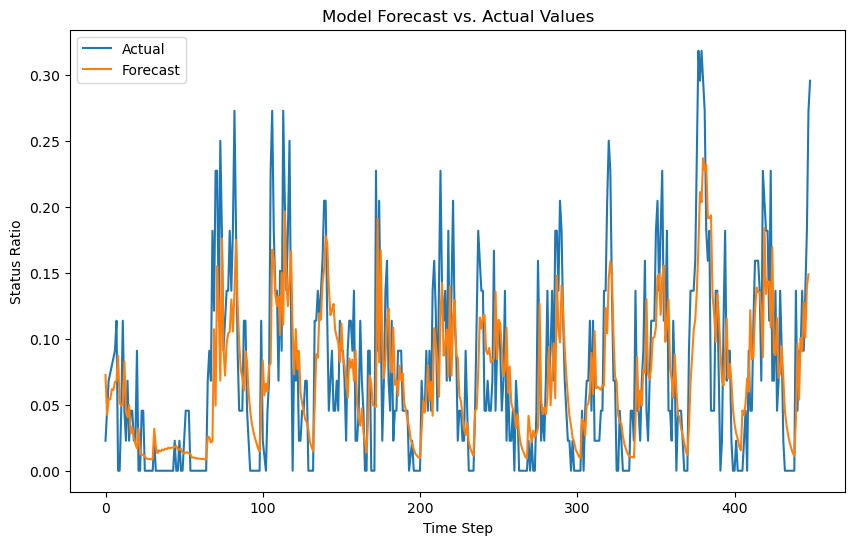

In [62]:
"""
Inspect individual stations 
"""
# Function to make predictions
def predict(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs.to(device).float()  # Convert input to float32
            outputs = model(inputs).squeeze().detach().cpu().numpy()  # Detach from the computational graph and move to CPU
            predictions.extend(outputs)
    return predictions

# Get test sequences and targets for a specific charging station
node_index = (8.620159, 56.361676)  # Example index
test_sequences = grouped_data_tensors[node_index]['test_sequences']
test_targets = grouped_data_tensors[node_index]['test_targets']

# Remove the last entry
test_sequences = test_sequences[:-1]

# Verify the new length of test_sequences
print("New length of test_sequences:", len(test_sequences))

print(len(test_targets))

# Make predictions for this charging station
test_dataloader = DataLoader(test_sequences, batch_size=64, shuffle=False)
station_predictions = predict(model, test_dataloader)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_targets, label='Actual')
plt.plot(station_predictions, label='Forecast')
plt.xlabel('Time Step')
plt.ylabel('Status Ratio')
plt.title('Model Forecast vs. Actual Values')
plt.legend()
plt.show()

#coordinates_to_remove = [
#    (8.141860, 55.555610),
#    (12.163113, 55.489025),
#    (8.620159, 56.361676),
#]



### Evaluation on new stations 